In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## load mass

In [15]:
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=200)

In [16]:
annotations.head()

,type,subjectId,startTime,duration,expert,comment,labelerId,samplerate,stopTime,startInd,stopInd
0,spindle,0001,888.569501,0.640579,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,889.210080,177714,177842
1,spindle,0001,905.999757,0.578094,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,906.577851,181200,181316
2,spindle,0001,917.973270,0.847603,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,918.820873,183595,183764
3,spindle,0001,922.319885,0.878845,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,923.198730,184464,184640
4,spindle,0001,939.297141,0.757767,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,940.054908,187859,188011


In [17]:
signalsMetadata.head()

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False


## TBD - access DREAMS and COGNITION in the same way

## load cognition

In [3]:
def loadCOGNITIONSpindles(path):
    #signalsMetadata
    signalsMetadata=pd.read_csv(path+'\\signals\\signalsMetadata.csv')
    signalsMetadata['subjectId']=signalsMetadata.apply(
        lambda row: str(row.subjectId).zfill(4),axis=1)

    #subjectsMetadata
    subjectsMetadata=pd.read_csv(path+'\\signals\\subjectsMetadata.csv')
    subjectsMetadata['subjectId']=subjectsMetadata.apply(
        lambda row: str(row.subjectId).zfill(4),axis=1)

    #load signals from .txt
    signals={}
    for index, row in signalsMetadata.iterrows():
        signals[row.subjectId]=np.loadtxt(path+'\\signals\\'+row.filename)

    #spindle annotations
    annotationsMetadata=pd.read_csv(path+'\\annotations\\annotationsMetadata.csv')
    annotationsMetadata['subjectId']=annotationsMetadata.apply(
        lambda row: str(row.subjectId).zfill(4),axis=1)
    annotationsMetadata['labelerId']=annotationsMetadata.apply(
        lambda row: str(row.labelerId).zfill(4),axis=1)

    #populate annotations metadata
    annotations=pd.DataFrame(columns=['startTime','duration','channel','subjectId','labelerId','type'])
    for index,row in annotationsMetadata.iterrows():
        aux=pd.read_csv(path+'\\annotations\\'+row.filename,index_col=False)
        aux['channel']=row.channel
        aux['subjectId']=row.subjectId
        aux['labelerId']=row.labelerId
        aux['type']='spindle'
        annotations=pd.concat((annotations,aux))

    #add stop and index colums
    annotations=annotations.merge(signalsMetadata[['subjectId','samplerate']],how='left',on='subjectId')
    annotations['stopTime']=annotations.apply(
        lambda row: row.startTime+row.duration , axis=1)
    annotations['startInd']=annotations.apply(
        lambda row: seconds2index(row.startTime,row.samplerate) , axis=1)
    annotations['stopInd']=annotations.apply(
        lambda row: seconds2index(row.stopTime,row.samplerate) , axis=1)
    annotations=annotations.reset_index()

    return signals, annotations, signalsMetadata, subjectsMetadata, annotationsMetadata

In [4]:
signals, annotations, signalsMetadata, subjectsMetadata, annotationsMetadata = loadCOGNITIONSpindles(cognipath)

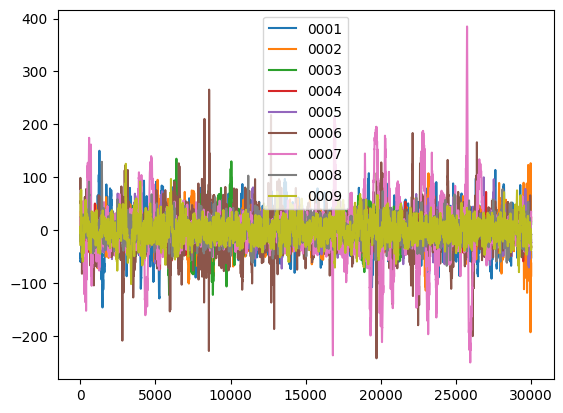

In [10]:
names=[]
for subject,signal in signals.items():
    plt.plot(signal[20000:50000])
    names.append(subject)
plt.legend(names)
plt.show()

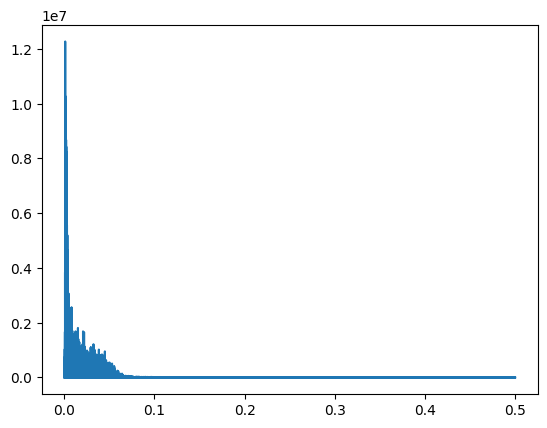

In [11]:
plt.plot(sg.periodogram(signals['0001'])[0],sg.periodogram(signals['0001'])[1])

TBD: you need to correct this below!

In [11]:
annotations

,index,startTime,duration,channel,subjectId,labelerId,type,Canal,Inicio,Fin,Duracion,Fase,samplerate,stopTime,startInd,stopInd
0,0,NaN,NaN,C3-M2,0001,0001,spindle,C3,1938.132297,1939.202326,1.070029,2.0,500,NaN,-2147483648,-2147483648
1,1,NaN,NaN,C3-M2,0001,0001,spindle,C3,2047.217898,2048.112834,0.894936,2.0,500,NaN,-2147483648,-2147483648
2,2,NaN,NaN,C3-M2,0001,0001,spindle,C3,2170.856032,2171.634237,0.778205,3.0,500,NaN,-2147483648,-2147483648
3,3,NaN,NaN,C3-M2,0001,0001,spindle,C3,2219.766538,2220.894943,1.128405,3.0,500,NaN,-2147483648,-2147483648
4,4,NaN,NaN,C3-M2,0001,0001,spindle,C3,2263.482492,2264.357974,0.875482,3.0,500,NaN,-2147483648,-2147483648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2780,2780,NaN,NaN,C3-M2,0009,0001,spindle,C3,39234.883269,39235.680928,0.797659,3.0,500,NaN,-2147483648,-2147483648
2781,2781,NaN,NaN,C3-M2,0009,0001,spindle,C3,39287.062257,39287.801552,0.739295,3.0,500,NaN,-2147483648,-2147483648
2782,2782,NaN,NaN,C3-M2,0009,0001,spindle,C3,39381.653696,39383.463024,1.809328,0.0,500,NaN,-2147483648,-2147483648
2783,2783,NaN,NaN,C3-M2,0009,0001,spindle,C3,39401.459144,39402.276262,0.817118,0.0,500,NaN,-2147483648,-2147483648


In [12]:
signalsMetadata

,filename,channel,subjectId,duration,samplerate
0,COG001_canal_C3.txt,C3-M2,0001,39600,500
1,COG002_canal_C3.txt,C3-M2,0002,39600,500
2,COG003_canal_C3.txt,C3-M2,0003,39600,500
3,COG004_canal_C3.txt,C3-M2,0004,39600,500
4,COG005_canal_C3.txt,C3-M2,0005,39600,500
5,COG006_canal_C3.txt,C3-M2,0006,39600,500
6,COG007_canal_C3.txt,C3-M2,0007,39600,500
7,COG008_canal_C3.txt,C3-M2,0008,39600,500
8,COG009_canal_C3.txt,C3-M2,0009,39600,500


In [13]:
subjectsMetadata

,subjectId,age,weight,size,IMC,date,IAH,Chervin,Chervin_SAHS,BAS-II,PPVT-III,ENFEN-F1,ENFEN-F2,ENFEN-S1,ENFEN-S2,ENFEN-A,ENFEN-I
0,0001,6.7,28.0,124,18.2,28/01/2020,28.4,18,1,87,100,6,3,4,1,2,5
1,0002,7.3,31.0,130,18.3,04/02/2020,25.2,6,0,121,98,5,9,6,8,5,7
2,0003,8.7,40.5,132,23.2,25/02/2020,3.0,15,1,87,103,7,3,3,7,6,7
3,0004,8.1,36.0,138,18.9,26/02/2020,1.6,7,0,102,108,4,7,5,6,4,4
4,0005,9.6,33.8,138,17.7,04/03/2020,6.6,5,0,55,89,1,5,7,5,2,6
5,0006,7.6,28.0,125,17.9,05/03/2020,10.9,9,1,109,96,5,8,7,5,4,10
6,0007,7.5,32.0,135,17.6,10/03/2020,3.0,15,1,95,101,3,6,3,1,3,7
7,0008,6.4,17.0,113,13.3,11/03/2020,3.7,11,1,109,112,6,5,8,5,3,7
8,0009,6.6,23.0,127,14.3,12/03/2020,27.4,15,1,98,107,5,5,6,1,5,7


In [14]:
annotationsMetadata

,filename,channel,subjectId,labelerId
0,COG001_spindle_c3.csv,C3-M2,0001,0001
1,COG002_spindle_c3.csv,C3-M2,0002,0001
2,COG003_spindle_c3.csv,C3-M2,0003,0001
3,COG004_spindle_c3.csv,C3-M2,0004,0001
4,COG005_spindle_c3.csv,C3-M2,0005,0001
5,COG006_spindle_c3.csv,C3-M2,0006,0001
6,COG007_spindle_c3.csv,C3-M2,0007,0001
7,COG008_spindle_c3.csv,C3-M2,0008,0001
8,COG009_spindle_c3.csv,C3-M2,0009,0001


## create a dataframe with the features available

In [3]:
#general parameters
samplerates=[200]
windowDurations=[0.5,0.25,1.5,3]
bands={
    'spindle':[10,16],
    'delta':[0,4],
    'theta':[4,8],
    'alpha':[8,12],
    'sigma':[12.5,15],
    'beta':[12,30]
    }
subjectIds=list(subjectsMetadata.subjectId)

In [4]:
allSamplerates=[]
allWindows=[]
allSubjectIds=[]
allCharacteristics=[]
allBandNames=[]

for samplerate in samplerates:
    for window in windowDurations:
        for subject in subjectIds:
            thisPath=featurespath+'/'+str(samplerate)+'fs/'+str(window)+'win/'+subject
            fullfileList=os.listdir(thisPath)
            for fullfile in fullfileList:
                #remove extension
                namefile=fullfile[:-3]
                #separate fields
                characteristic,band=namefile.split('_')[2:4]
                allSamplerates.append(samplerate)
                allWindows.append(window)
                allSubjectIds.append(subject)
                allCharacteristics.append(characteristic)
                allBandNames.append(band)

fullFeaturesDf=pd.DataFrame({
    'samplerate':allSamplerates,
    'window':allWindows,
    'subjectId':allSubjectIds,
    'characteristic':allCharacteristics,
    'bandName':allBandNames
})

#we need this to load the features in a fixed order
simpleFeatureDf=fullFeaturesDf[['characteristic','bandName']].drop_duplicates()

In [5]:
simpleFeatureDf

,characteristic,bandName
0,CTM,alpha
1,CTM,beta1
2,CTM,beta2
3,CTM,broadband
4,CTM,delta1
...,...,...
121,symmetry,broadband
122,symmetry,delta1
123,symmetry,delta2
124,symmetry,sigma


In [6]:
#126 features
len(simpleFeatureDf)

126

In [7]:
#126 feature by 8 subjects by 4 window
len(fullFeaturesDf)==126*8*4

True

## samplerate and excerpDimension
needs improvements

In [8]:
samplerate=200

#You need a way to extend this to data that is not so regular ---------------------->
excerptDimension=len(signals['0001'])
#<-----------------------------------------------------------------------------------

## data splits definition

In [9]:
usedSubjects=np.array(["0001","0002","0003","0005","0006"])

In [10]:
valCount=1
trainSplits=[]
valSplits=[]
testSplits=[]
for i in range(len(usedSubjects)):
    thisTest=usedSubjects[i]
    thisNoTest=np.setdiff1d(usedSubjects,thisTest)
    thisVal=np.random.choice(thisNoTest,size=valCount,replace=False)
    thisTrain=np.setdiff1d(thisNoTest,thisVal)
    trainSplits.append(thisTrain)
    valSplits.append(thisVal)
    testSplits.append(thisTest)

dataSplits=pd.DataFrame({
    'train':trainSplits,
    'val':valSplits,
    'test':testSplits
})

In [11]:
dataSplits

,train,val,test
0,"[0002, 0003, 0006]",[0005],0001
1,"[0001, 0003, 0005]",[0006],0002
2,"[0001, 0002, 0006]",[0005],0003
3,"[0001, 0003, 0006]",[0002],0005
4,"[0001, 0002, 0005]",[0003],0006


In [12]:
#Using a feature proposal defined
iteration=7
cFile = open("EXT_F1_iteration_"+str(iteration)+".pkl", 'rb')
selectedFeatureDf = pkl.load(cFile)
cFile.close()

In [13]:
selectedFeatureDf=selectedFeatureDf.reset_index(drop=True)
selectedFeatureDf

,characteristic,bandName,window
0,hjortActivity,sigma,0.5
1,petrosian,broadband,0.5
2,hjortActivity,theta,0.5
3,relativePower,beta1,0.5
4,hjortComplexity,sigma,0.5


In [14]:
window=0.5    #must change this

In [15]:
models=[]
treeLimits=[]
valF1s=[]
for index, row in dataSplits.iterrows():
    #Features
    trainFeatures=loadFeatureMatrix(row.train,selectedFeatureDf,excerptDimension,window,samplerate,featurespath)
    valFeatures=loadFeatureMatrix(row.val,selectedFeatureDf,excerptDimension,window,samplerate,featurespath)    #<-Warning! we are appending the validation signals one after the other!!!
    #Labels
    trainLabels=loadLabelsVector(row.train,annotations,excerptDimension)
    valLabels=loadLabelsVector(row.val,annotations,excerptDimension)
    #Train the models
    xgb_model = xgb.XGBClassifier(n_jobs=8).fit(trainFeatures, trainLabels, early_stopping_rounds=3, eval_metric="logloss",eval_set=[(valFeatures,valLabels)],verbose=0)
    models.append(xgb_model)
    treeLimits.append(xgb_model.best_ntree_limit)
    #val predictions and objective function definition
    valPredictions=xgb_model.predict(valFeatures, ntree_limit=xgb_model.best_ntree_limit)
    valF1s.append(F1(valLabels,valPredictions))

dataSplits["model"]=models
dataSplits["treeLimit"]=treeLimits
dataSplits["valF1"]=valF1s


\\desktop-447dqph\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
\\desktop-447dqph\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  w

In [16]:
del models, treeLimits, valF1s, trainFeatures, valFeatures, trainLabels, valLabels, xgb_model

In [17]:
with open("CVOut_"+str(time.time())+".pkl", 'wb') as file:
    pkl.dump({"features":selectedFeatureDf,"results":dataSplits}, file)

In [18]:
dataSplits

,train,val,test,model,treeLimit,valF1
0,"[0002, 0003, 0006]",[0005],0001,"XGBClassifier(base_score=0.5, booster='gbtree'...",20,0.594912
1,"[0001, 0003, 0005]",[0006],0002,"XGBClassifier(base_score=0.5, booster='gbtree'...",19,0.633560
2,"[0001, 0002, 0006]",[0005],0003,"XGBClassifier(base_score=0.5, booster='gbtree'...",21,0.584836
3,"[0001, 0003, 0006]",[0002],0005,"XGBClassifier(base_score=0.5, booster='gbtree'...",26,0.630363
4,"[0001, 0002, 0005]",[0003],0006,"XGBClassifier(base_score=0.5, booster='gbtree'...",29,0.522570


## Prepare for testing

In [19]:
def labelingProcess(labelVector,maxTimeClose,minDuration,samplerate):
    aux=ndi.label(labelVector)
    preCandidates=ndi.find_objects(aux[0])
    if len(preCandidates)>0:    #consider the case of no precandidates at all
        #1. Join candidates separated by less than the threshold
        kernelLength=int(maxTimeClose*samplerate)
        if kernelLength>0:
            kernel=np.ones((kernelLength,))
            labelVector=ndi.binary_closing(labelVector,kernel)
        #2. Discard candidates under minimum duration
        aux=ndi.label(labelVector)
        candidates=ndi.find_objects(aux[0])
        labelVector=np.zeros_like(labelVector)
        if len(candidates)>0:
            durations=np.apply_along_axis(lambda x: (x[0].stop-x[0].start)/samplerate,1,candidates)
            detections=[candidates[i] for i in np.where(durations>minDuration)[0]]
            for detection in detections:
                labelVector[detection]=1
    return labelVector
    
def fullLabelingScore(groundTruth,predictions,maxTimeClose,minDuration,samplerate):
    cleanedPredictions=labelingProcess(predictions,maxTimeClose,minDuration,samplerate)
    return F1(groundTruth,cleanedPredictions)

def labelIntersectionIoU(label,annotations):
    isIntersect=annotations.apply(
        lambda row: ((label.startInd>=row.startInd)&(label.startInd<row.stopInd)) | ((row.startInd>=label.startInd)&(row.startInd<label.stopInd))
        ,axis=1)

    labelIntersect=None

    #output lenght should be equal 1 or 0 (at least now)
    aux=np.sum(isIntersect)
    if aux==0:
        IoU=0
    else:
        if aux>1:   #<----------- beware of labels with more than 1 intersecting detection
            print("Warning: multiple overlap")
            print(aux)
        labelIndexes=np.arange(label.startInd,label.stopInd)
        allIntersections=np.where(isIntersect)[0]
        intersectingIndexes=np.array([])
        for i in allIntersections:
            intersecting=annotations.loc[i]
            tempIndexes=np.arange(intersecting.startInd,intersecting.stopInd)
            overlap=np.intersect1d(labelIndexes,tempIndexes)
            if (len(overlap)>len(intersectingIndexes)): #select only maximal overlap
                intersectingIndexes=tempIndexes
                labelIntersect=i
        IoU=len(np.intersect1d(labelIndexes,intersectingIndexes))/len(np.union1d(labelIndexes,intersectingIndexes))
    return IoU, labelIntersect

def byEventF1(unionAnnotations,predictedAnnotations):
    #by event metrics
    unionAnnotations[['IoU','intersectsWith']]=unionAnnotations.apply(
    lambda row: labelIntersectionIoU(row,predictedAnnotations)
    ,axis=1, result_type ='expand')

    annotationsNoOverlap=np.array(unionAnnotations[unionAnnotations.intersectsWith.isna()].index)
    unionAnnotationsOverlap=unionAnnotations.iloc[np.setdiff1d(np.array(unionAnnotations.index),annotationsNoOverlap)]
    detectionsOverThreshold=np.array(unionAnnotationsOverlap[unionAnnotationsOverlap.IoU>0.2].intersectsWith)
    detectionsBelowThreshold=np.array(unionAnnotationsOverlap[unionAnnotationsOverlap.IoU<0.2].intersectsWith)
    detectionsConsidered=np.union1d(detectionsOverThreshold,detectionsBelowThreshold)
    detecionsNotConsidered=np.setdiff1d(
        np.array(predictedAnnotations.index),
        detectionsConsidered
    )

    tp=len(detectionsOverThreshold)
    fp=len(detecionsNotConsidered)+len(detectionsBelowThreshold)
    fn=len(annotationsNoOverlap)+len(detectionsBelowThreshold)
    f1_event=2*tp/(2*tp+fp+fn)

    return f1_event

In [20]:
n=10
""" t0=np.linspace(0.1,0.75,n)
t1=np.linspace(0.1,0.75,n) """
t0=np.linspace(0.1,0.55,10)
t1=np.linspace(0.1,0.55,10)
t0=np.repeat(t0[:,np.newaxis],n,1)
t1=np.transpose(np.repeat(t1[:,np.newaxis],n,1))
t0=t0.flatten()
t1=t1.flatten()

In [21]:
testF1s=[]
imgs=[]
regs=[]
for index, row in dataSplits.iterrows():
    #Features
    testFeatures=loadFeatureMatrix([row.test],selectedFeatureDf,excerptDimension,window,samplerate,featurespath)
    #Labels
    testLabels=loadLabelsVector([row.test],annotations,excerptDimension)
    #Model
    xgb_model=row.model
    #Predict
    #val predictions and objective function definition
    testPredictions=xgb_model.predict(testFeatures, ntree_limit=row.treeLimit)
    testF1s.append(F1(testLabels,testPredictions))

    unionAnnotations=labelVectorToAnnotations(testLabels,samplerate)

    img=[]
    reg=[]
    for t in zip(t0,t1):
        processedTestPredictions=labelingProcess(testPredictions,t[0],t[1],samplerate)
        predictedAnnotations=labelVectorToAnnotations(processedTestPredictions,samplerate)
        img.append(byEventF1(unionAnnotations,predictedAnnotations))
        reg.append(t[0]**2+t[1]**2)
    img=np.array(img)
    img=img.reshape((n,n))
    reg=np.array(reg)
    reg=reg.reshape((n,n))

    imgs.append(img)
    regs.append(reg)

\\desktop-447dqph\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


\\desktop-447dqph\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


\\desktop-447dqph\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2
2
2
2
2
2
2
2
2
2
2


\\desktop-447dqph\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2
2
2
2
2


\\desktop-447dqph\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [22]:
dataSplits["testRawF1"]=testF1s
dataSplits["img"]=imgs
dataSplits["reg"]=regs
dataSplits

,train,val,test,model,treeLimit,valF1,testRawF1,img,reg
0,"[0003, 0005, 0006]",[0002],0001,"XGBClassifier(base_score=0.5, booster='gbtree'...",25,0.584318,0.581108,"[[0.6842105263157895, 0.7147766323024055, 0.74...","[[0.020000000000000004, 0.03250000000000001, 0..."
1,"[0001, 0005, 0006]",[0003],0002,"XGBClassifier(base_score=0.5, booster='gbtree'...",27,0.528931,0.612993,"[[0.6341463414634146, 0.6701570680628273, 0.70...","[[0.020000000000000004, 0.03250000000000001, 0..."
2,"[0002, 0005, 0006]",[0001],0003,"XGBClassifier(base_score=0.5, booster='gbtree'...",17,0.578722,0.514032,"[[0.6136363636363636, 0.6506024096385542, 0.66...","[[0.020000000000000004, 0.03250000000000001, 0..."
3,"[0001, 0002, 0003]",[0006],0005,"XGBClassifier(base_score=0.5, booster='gbtree'...",16,0.629171,0.572690,"[[0.6474820143884892, 0.6592592592592592, 0.70...","[[0.020000000000000004, 0.03250000000000001, 0..."
4,"[0002, 0003, 0005]",[0001],0006,"XGBClassifier(base_score=0.5, booster='gbtree'...",17,0.567843,0.628491,"[[0.7473309608540926, 0.7518248175182481, 0.77...","[[0.020000000000000004, 0.03250000000000001, 0..."


In [23]:
avg=np.zeros((n,n))
opt=np.zeros((n,n))
count=0
for index, row in dataSplits.iterrows():
    avg=avg+row.img
    reg=row.reg
    count=count+1
avg=avg/count


In [24]:
px.imshow(avg)

In [25]:
avgClose=t0[np.argmax(avg.flatten())]
avgDuration=t1[np.argmax(avg.flatten())]
print("Optimal closing, average: "+str(avgClose))
print("Optimal duration thres, average: "+str(avgDuration))

Optimal closing, average: 0.55
Optimal duration thres, average: 0.25


In [26]:
opt=avg-reg/20

In [27]:
px.imshow(reg/20)

In [28]:
px.imshow(opt)

In [29]:
optClose=t0[np.argmax(opt.flatten())]
optDuration=t1[np.argmax(opt.flatten())]
print("Optimal closing, regularization: "+str(optClose))
print("Optimal duration thres, regularization: "+str(optDuration))

Optimal closing, regularization: 0.2
Optimal duration thres, regularization: 0.3500000000000001


In [30]:
f1_byEvent_CV=avg.flatten()[np.argmax(opt.flatten())]

In [31]:
f1_byEvent_CV

0.7387414491283774

In [32]:
dataSplits

,train,val,test,model,treeLimit,valF1,testRawF1,img,reg
0,"[0003, 0005, 0006]",[0002],0001,"XGBClassifier(base_score=0.5, booster='gbtree'...",25,0.584318,0.581108,"[[0.6842105263157895, 0.7147766323024055, 0.74...","[[0.020000000000000004, 0.03250000000000001, 0..."
1,"[0001, 0005, 0006]",[0003],0002,"XGBClassifier(base_score=0.5, booster='gbtree'...",27,0.528931,0.612993,"[[0.6341463414634146, 0.6701570680628273, 0.70...","[[0.020000000000000004, 0.03250000000000001, 0..."
2,"[0002, 0005, 0006]",[0001],0003,"XGBClassifier(base_score=0.5, booster='gbtree'...",17,0.578722,0.514032,"[[0.6136363636363636, 0.6506024096385542, 0.66...","[[0.020000000000000004, 0.03250000000000001, 0..."
3,"[0001, 0002, 0003]",[0006],0005,"XGBClassifier(base_score=0.5, booster='gbtree'...",16,0.629171,0.572690,"[[0.6474820143884892, 0.6592592592592592, 0.70...","[[0.020000000000000004, 0.03250000000000001, 0..."
4,"[0002, 0003, 0005]",[0001],0006,"XGBClassifier(base_score=0.5, booster='gbtree'...",17,0.567843,0.628491,"[[0.7473309608540926, 0.7518248175182481, 0.77...","[[0.020000000000000004, 0.03250000000000001, 0..."


### Add F1 by sample and by event

In [33]:
testSampleF1s=[]
testEventF1s=[]

for index, row in dataSplits.iterrows():
    testEventF1s.append(row.img.flatten()[np.argmax(opt.flatten())])

    #Features
    testFeatures=loadFeatureMatrix([row.test],selectedFeatureDf,excerptDimension,window,samplerate,featurespath)
    #Labels
    testLabels=loadLabelsVector([row.test],annotations,excerptDimension)
    #Model
    xgb_model=row.model
    #Predict
    testPredictions=xgb_model.predict(testFeatures, ntree_limit=row.treeLimit)
    processedTestPredictions=labelingProcess(testPredictions,optClose,optDuration,samplerate)
    testSampleF1s.append(F1(testLabels,processedTestPredictions))


    
dataSplits["testEventF1"]=testEventF1s
dataSplits["testSampleF1"]=testSampleF1s

\\desktop-447dqph\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

\\desktop-447dqph\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

\\desktop-447dqph\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

\\desktop-447dqph\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

\\desktop-447dqph\Users\Gurdiel\Code\Testing\venv\lib\site-packages\xgboost\core.py:91: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



In [34]:
dataSplits

,train,val,test,model,treeLimit,valF1,testRawF1,img,reg,testEventF1,testSampleF1
0,"[0003, 0005, 0006]",[0002],0001,"XGBClassifier(base_score=0.5, booster='gbtree'...",25,0.584318,0.581108,"[[0.6842105263157895, 0.7147766323024055, 0.74...","[[0.020000000000000004, 0.03250000000000001, 0...",0.746032,0.622279
1,"[0001, 0005, 0006]",[0003],0002,"XGBClassifier(base_score=0.5, booster='gbtree'...",27,0.528931,0.612993,"[[0.6341463414634146, 0.6701570680628273, 0.70...","[[0.020000000000000004, 0.03250000000000001, 0...",0.725000,0.646556
2,"[0002, 0005, 0006]",[0001],0003,"XGBClassifier(base_score=0.5, booster='gbtree'...",17,0.578722,0.514032,"[[0.6136363636363636, 0.6506024096385542, 0.66...","[[0.020000000000000004, 0.03250000000000001, 0...",0.702703,0.553329
3,"[0001, 0002, 0003]",[0006],0005,"XGBClassifier(base_score=0.5, booster='gbtree'...",16,0.629171,0.572690,"[[0.6474820143884892, 0.6592592592592592, 0.70...","[[0.020000000000000004, 0.03250000000000001, 0...",0.724891,0.599886
4,"[0002, 0003, 0005]",[0001],0006,"XGBClassifier(base_score=0.5, booster='gbtree'...",17,0.567843,0.628491,"[[0.7473309608540926, 0.7518248175182481, 0.77...","[[0.020000000000000004, 0.03250000000000001, 0...",0.795082,0.670757


In [35]:
np.mean(dataSplits.testEventF1)

0.7387414491283774

In [36]:
np.std(dataSplits.testEventF1)

0.03132685982917773

In [37]:
np.mean(dataSplits.testSampleF1)

0.6185615223400218

In [38]:
np.std(dataSplits.testSampleF1)

0.040313586299957745